# W.2. Treasury Debt

## Financial Analytics

### UChicago ADSP

#### Spring 2024

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

# Data Source

CRSP Treasury Monthly Release
accessed via WRDS

For any given date, obtain quotes for nearly every issued Treasury.

In particular, 
* Bills, Notes, Bonds
* TIPS

In the analysis below, we exclude TIPS to focus on nominal rates.

The data set does not include Floating Rate Notes (FRNs).

In [2]:
QUOTE_DATE = '2024-02-28'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

In [3]:
t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

In [4]:
f'Analysis based on quotes from: {pd.to_datetime(t_current):%Y-%m-%d}'

'Analysis based on quotes from: 2024-02-28'

In [5]:
warnings.filterwarnings('ignore',category=FutureWarning)

metrics = rawdata.copy()[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']]
metrics.columns = ['issue date','maturity date','coupon rate','ytm','duration','outstanding']
metrics['ytm'] *= 365
metrics['duration'] /= 365
metrics['outstanding'] *= 1e6
metrics['maturity'] = get_maturity_delta(metrics['maturity date'], t_current)
metrics['price'] = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
metrics['ask-bid'] = rawdata['TDASK'] - rawdata['TDBID']
metrics['next cashflow date'] = (calc_cashflows(rawdata) != 0).idxmax(1)
metrics = metrics[['issue date','maturity date','maturity','coupon rate','next cashflow date','price','ytm','ask-bid']]

warnings.filterwarnings('default', category=FutureWarning)

In [6]:
metrics

,issue date,maturity date,maturity,coupon rate,next cashflow date,price,ytm,ask-bid
KYTREASNO,,,,,,,,
207065,2017-02-28,2024-02-29,0.002738,2.125,2024-02-29,101.056662,0.021085,0.031250
207843,2022-02-28,2024-02-29,0.002738,1.500,2024-02-29,100.745879,0.014930,0.031250
207325,2019-02-28,2024-02-29,0.002738,2.375,2024-02-29,101.180975,0.023537,0.031250
208097,2023-08-31,2024-02-29,0.002738,0.000,2024-02-29,99.985597,0.052574,0.000028
208124,2023-11-07,2024-03-05,0.016427,0.000,2024-03-05,99.912167,0.053455,0.000167
...,...,...,...,...,...,...,...,...
208062,2023-05-15,2053-05-15,29.210130,3.625,2024-05-15,87.920673,0.043788,0.062500
208107,2023-08-15,2053-08-15,29.462012,4.125,2024-08-15,95.244978,0.043733,0.062500
208149,2023-11-15,2053-11-15,29.713895,4.750,2024-05-15,107.057692,0.043536,0.062500


# Basics of Treasuries

## Timing

These quotes are at a single point in time.

But they describe bonds covering a wide range of 
* issuance dates
* maturity dates

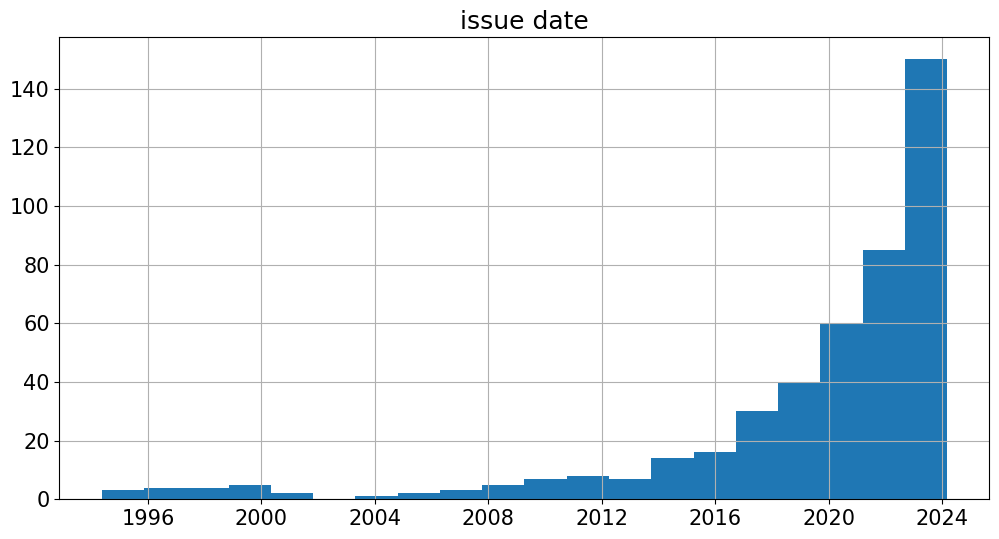

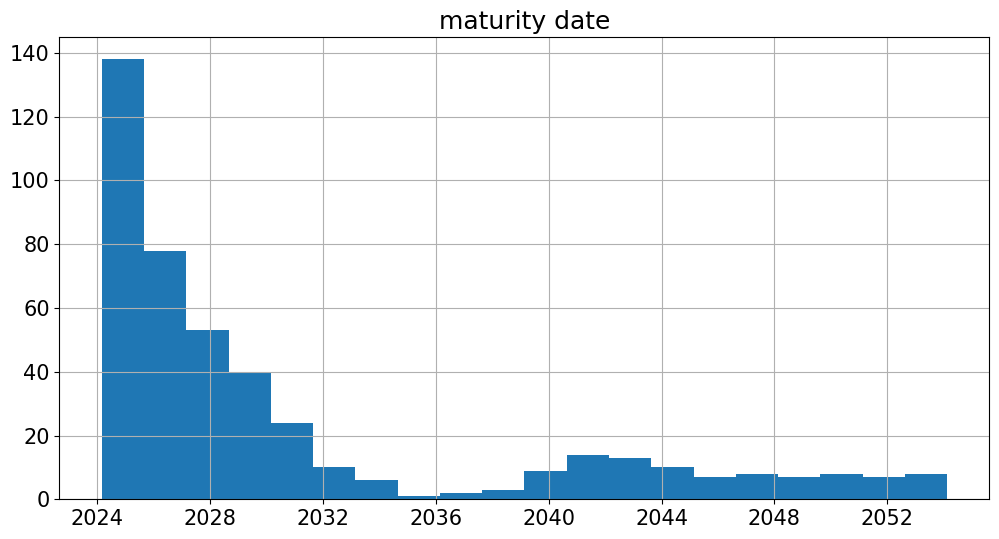

In [7]:
metrics.hist('issue date',bins=20)
metrics.hist('maturity date',bins=20)
plt.show()

## Coupon Rates

The quoted coupon is the annualized rate (per $100 face value).

It is paid semiannually.

The coupon rate is a feature set by the issuer (Treasury) at the time it is issued.
* These rates have varied widely over time.
* The Treasury sets coupons near the prevailing interest rate, (i.e., priced near par.)

In the figure below, note that coupon rates have declined over time.

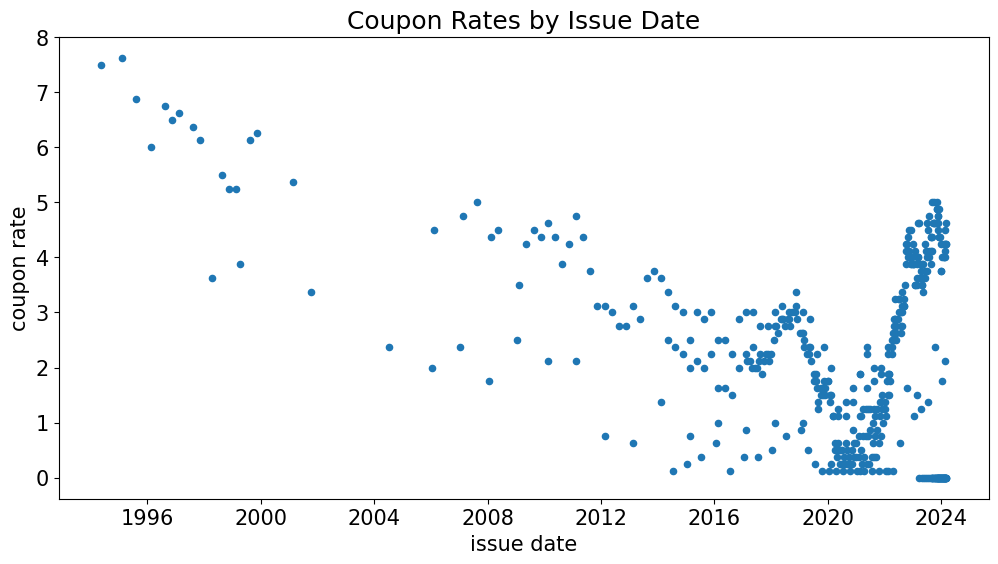

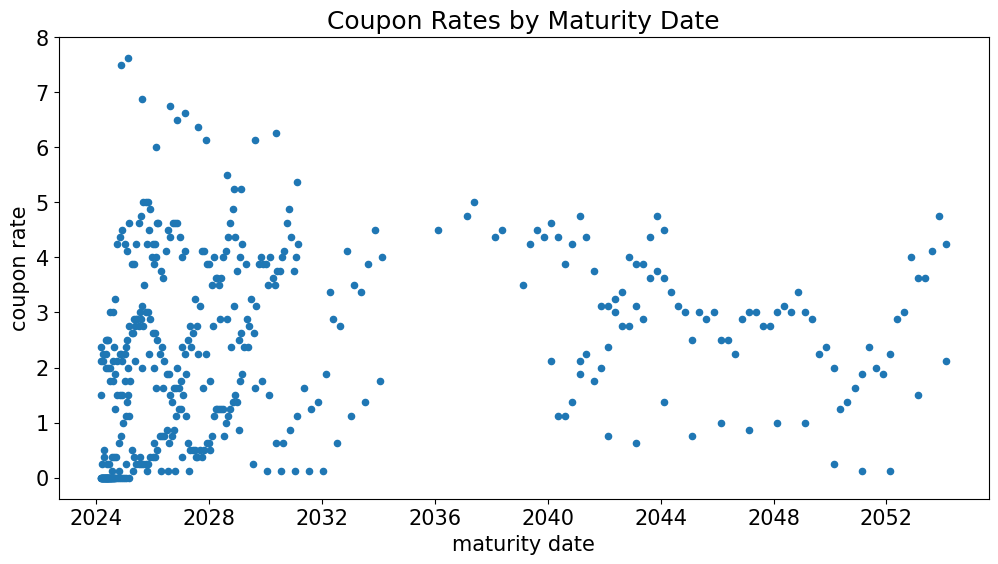

In [8]:
metrics.plot.scatter(x='issue date',y='coupon rate',title='Coupon Rates by Issue Date')
metrics.plot.scatter(x='maturity date',y='coupon rate',title='Coupon Rates by Maturity Date')
plt.show()

# Issue Types

|         | Maturity            | Coupon   | Coupon Frequency | Principal          |
|---------|---------------------|----------|------------------|--------------------|
| T-bills | 4, 8, 13, 26, 52 weeks | None     | None             | Fixed              |
| T-notes | 2, 5, 7, 10 years      | Fixed    | Semiannual       | Fixed              |
| T-bonds | 20, 30 years            | Fixed    | Semiannual       | Fixed              |
| TIPS    | 5, 10, 30 years     | Fixed    | Semiannual       | Inflation adjusted |
| FRNs    | 2 years             | Floating | Quarterly        | Fixed              |
| STRIPS  | Derived             | None     | None             | Fixed              |

Reference: 
https://www.treasurydirect.gov/indiv/research/indepth/tbills/res_tbill.htm


## Traditional Treasury Debt Securities

### Bills
* maturity $\le$ 1 year
* no coupon

### Notes
* 1 year $<$ maturity $\le 10$ years
* semiannual coupon

### Bonds
* maturity $> 10$ years
* semiannual coupon

## Other Instruments

### TIPS

**Treasury Inflation Protected Securities** (TIPS)
- Treasury notes and bonds (no bills)
- Semiannual coupon
- Issued since 1997

**Inflation protection**

TIPS provide a hedge against inflation.
- Face value is scaled by CPI
- Coupon rate is fixed
- Fixed coupon rate multiplies the (CPI-adjusted) face-value, which leads to an inflation-adjusted coupon

### Floating Rate Notes (FRN)
* maturity of 2-years
* floating coupon
* quarterly payment

Discussed in more depth later.

### STRIPS

STRIPS are registered securities created by "stripping" the coupons and principal from an issued Treasury.

This allows investors to trade **zero coupon** bonds with maturities beyond 1 year.

https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/holdings-of-treasury-securities-in-stripped-form

# Composition

<img src='../refs/treasury_debt_composition_MSPD_2023.png'>

Reference: https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/summary-of-treasury-securities-outstanding

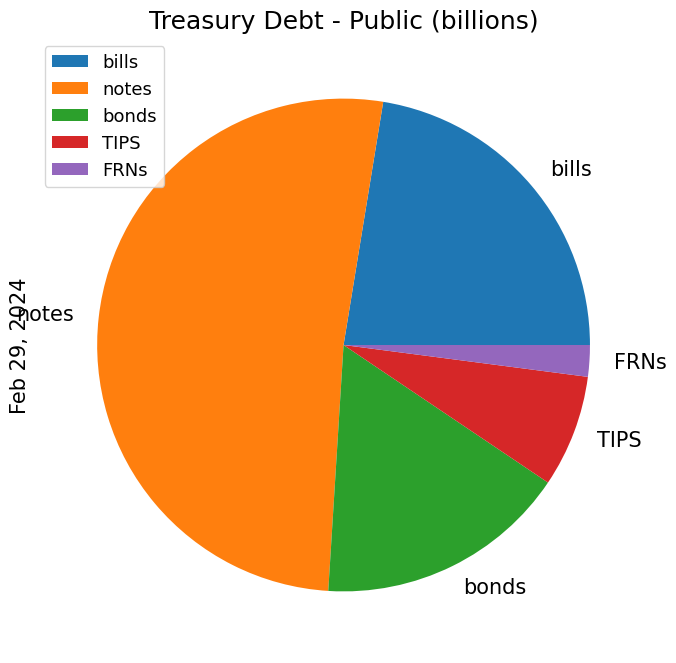

In [9]:
debt_outstanding = pd.DataFrame(index=['bills','notes','bonds','TIPS','FRNs'],data=[6010.1,13825.2,4438.2,1973.2,553.5],columns=['public debt (billions)'])
debt_outstanding.plot.pie(y=debt_outstanding.columns[0],figsize=(8,8),title='Treasury Debt - Public (billions)',ylabel='Feb 29, 2024')
plt.show()

# Dealers

Treasuries are bought by auction or in secondary markets.
* Primary dealers buy most new issues at auction and sell them all over the world.
* The New York Fed publishes a list of these dealers, along with a “Weekly Release of Primary Dealer Transactions”.
* Include Citigroup, Deutsche Bank, Morgan Stanley, Nomura, UBS.
* Recent additions or removals?

# Pricing

Price is quoted per $100 face value

### Par
A bond trading above face value is said to trade above par
#### Bonds with coupons larger than current interest rates will trade above par.
* Trade above par: coupons are large enough to more than offset the present value discount.


### Pricing function
The only features of an issue impacting price would be
* remaining maturity: $T-t$
* coupon rate

In a **frictionless market**, the 
* issue date would be irrelevant to the price.
* fresh 5-year note and 10-year note issued 5 years ago would have same price if same coupon rate.

But there are frictions and liquidity issues
* **on-the-run** bonds are the fresh (recent) issue and tend to have more liquidity and thus higher price.

### Bid-Ask Spread
The data set quotes a `bid` and `ask`.
* **Bid** is the price offered by a potential buyer
* **Ask** is the price offered by a potential seller
* For most issues, these are very close.

In [10]:
display(metrics.sort_values('ask-bid').head(5))
display(metrics[['ask-bid']].describe().T.style.format("{:.2f}"))

,issue date,maturity date,maturity,coupon rate,next cashflow date,price,ytm,ask-bid
KYTREASNO,,,,,,,,
208097,2023-08-31,2024-02-29,0.002738,0.0,2024-02-29,99.985597,0.052574,0.000028
208124,2023-11-07,2024-03-05,0.016427,0.0,2024-03-05,99.912167,0.053455,0.000167
208098,2023-09-07,2024-03-07,0.021903,0.0,2024-03-07,99.883333,0.053260,0.000222
208134,2023-11-14,2024-03-12,0.035592,0.0,2024-03-12,99.809514,0.053534,0.000361
208136,2023-11-28,2024-03-26,0.073922,0.0,2024-03-26,99.603813,0.053665,0.000375


,count,mean,std,min,25%,50%,75%,max
ask-bid,446.00,0.04,0.04,0.00,0.02,0.03,0.05,0.32


## On-the-run

Suppose you are interested in investing in a treasury with 5 years until maturity.

Consider two alternatives:
* buy a newly issued 5-year note
* buy a 10-year note that was issued 5 years ago

The newly issued note is **on-the-run**.

A treasury which has aged is **off-the-run**.

This is an important consideration in liquidity.
* financial intermediaries have substantial business in selling the on-the-run while hedging with the off-the-run.
* in some sense, this is trading on liquidity.

In [11]:
t_current = pd.to_datetime(QUOTE_DATE)
mats = get_maturity_delta(rawdata[['TMATDT']].astype('datetime64[ns]'), t_current=t_current)

metrics[mats['TMATDT'].between(4.9,5.1)].head(5).dropna().tail(2)

,issue date,maturity date,maturity,coupon rate,next cashflow date,price,ytm,ask-bid
KYTREASNO,,,,,,,,
204094,1999-02-15,2029-02-15,4.966461,5.25,2024-08-15,104.179688,0.042958,0.046875
208188,2024-02-29,2029-02-28,5.002053,4.25,2024-08-28,99.949219,0.042115,0.046875


## Quoting Conventions 

Bonds differ in maturity and coupons, so looking at their relative prices is an apple-to-oranges comparison.

**Yields** are a form of price quote that accounts for the maturity and coupon.

### YTM 

The YTM discussed above is the most important yield. 
* It is used in **quoting** and **analyzing** bonds.
* The YTM is not necessarily a sufficient statistics for all dimensions of a bond--price, coupon, maturity. Thus, two with equivalent YTM may have important differences.

### Discount yield
The discount yield is important for quoting money-market prices.
* it is not popular for analyzing and research
* it is perhaps vestigial to a time when traders needed to calculate by hand and calculator

**Treasury bills** are typically quoted as discount yields.

Consider
* price of $P$
* face value of 100
* no coupon

Then,
$$\text{discount yield} = \left(\frac{360}{n}\right)\frac{100-P}{100}$$

#### Example

A T-bill maturing in 90 days with cash price of $P=99$ will have discount yield of 
$$Y_{\text{discount}} = 4\%$$

Note that it will be common to go the other way around: read quotes for 90-day T-bills of 4\% (or simply, "4") and understand that as an actual price of 99.


<img src='../refs/treasury_quotes_bills.png'>

Reference: Bloomberg `B Govt`

## Price Quotes

T-notes and T-bonds are quoted in thirty-seconds (1/32) of a dollar rather than hundredths of a dollar.

<img src='../refs/treasury_quotes_bonds_notes.png'>

Reference: Bloomberg `T Govt`

## Accrued Interest

Accrued interest is proportional to the coupon rate, based on the number of days since the last coupon (or, until the next coupon.)

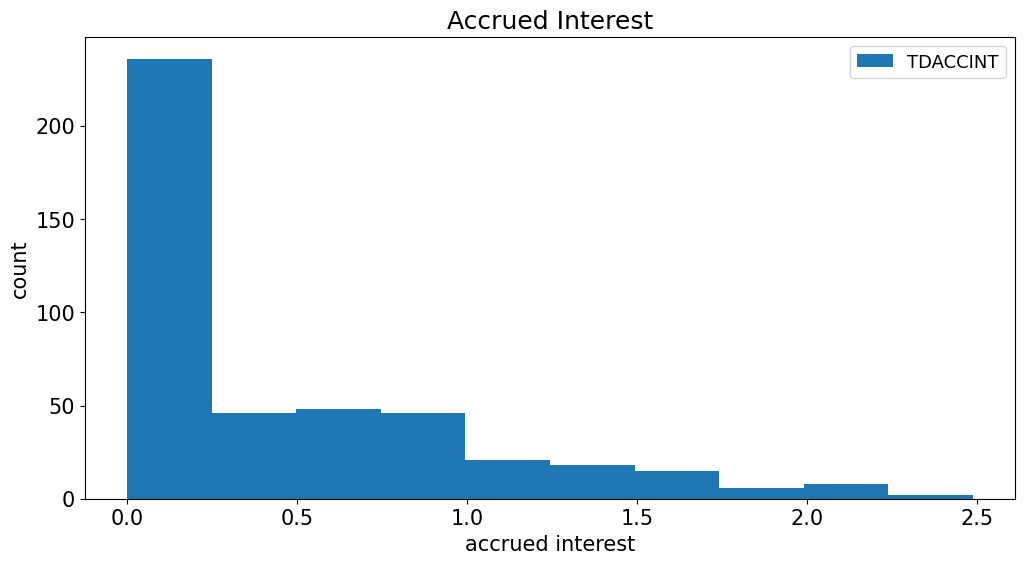

In [12]:
rawdata[['TDACCINT']].plot.hist(title='Accrued Interest',xlabel='accrued interest',ylabel='count');

### Day-Count Conventions

The accrued interest is computed with a day-count convention

$$\text{accrued interest} = \frac{\text{days counted}}{\text{days in reference period}} \times \text{interest in reference period}$$

Common day-count conventions include:
* actual/actual: treasury notes and bonds
* 30/360: corporate and municipal bonds
* actual/360: money-market instruments (issued with 1yr or less, little credit risk)

Careful, or can lead to seeming arbitrage that doesn't exist.
* Hull's Business Snapshot 6.1 mentions case of T-bond vs Corp and former getting 1 day of accrual Feb 28 to Mar 1, while latter gets 3 days of accrual.

We will not focus on the taxonomy of day-count conventions in discussions below.
* important to know what it is
* look it up when necessary

# Yield to Maturity (YTM) and Returns

The formula for YTM looks like the pricing formula for a bond, but replacing the maturity-dependent discount rate with a constant discount rate:

### Definition

Let $P_j(t,T,c)$ denote the price of 
- bond $j$ 
- observed time-$t$ 
- which matures at time $T$ 
- with coupons occuring at interim cashflow dates $T_i$ for $1\le i <n$
- and a final coupon and principal payment occuring at maturity $T$.

Define the **yield-to-maturity** for bond $j$ as the term $y_j$ which satisfies the following equation:

$\begin{align*}
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T-t)}}
\end{align*}
$

Note that the same rate, $y_j$, is discounting cashflows at different maturities.
* It is unique to the security, $j$.
* It is constant across the security's various cashflow maturities.

### YTM has a <span style='color:blue'>nonlinear</span> and <span style='color:blue'>inverse</span> relationship with price


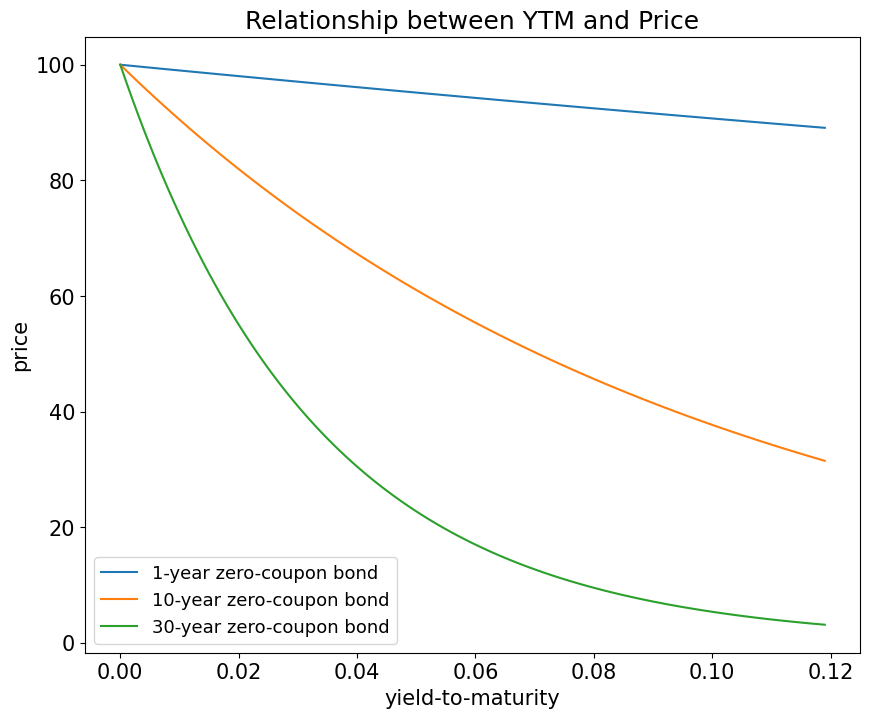

In [13]:
ylds_grid = np.arange(0,.12,.001)
T_grid = [1,10,30]
price_grid = pd.DataFrame(data=np.zeros([len(ylds_grid),len(T_grid)]), index=ylds_grid, columns=T_grid)
for T in T_grid:
    for i,y in enumerate(ylds_grid):
        price_grid.loc[y,T] = 100/(1+y/2)**(2*T)

price_grid.plot(figsize=(10,8))

legend_labels = [''] * len(T_grid)
for i,T in enumerate(T_grid):
    legend_labels[i] = f'{T}-year zero-coupon bond'

plt.xlabel('yield-to-maturity')
plt.ylabel('price')
plt.legend(legend_labels)
plt.title('Relationship between YTM and Price')
plt.show()

## Returns

The return on a bond between $t$ and $T$ is, like any security, the (time $T$) payoff divided by the (time $t$) price.

#### Notation
Let $\hat{r}_{t,T}$ denote the **annualized** return between $t$ and $T$. We use the hat, $\hat{r}$ to avoid confusion with the interest rate notation, $r(t,T)$.

$
\begin{align}
\hat{r}_{t,T} = \left(\frac{\text{payoff}_T}{\text{investment}_t}\right)^{\frac{1}{T-t}} - 1
\end{align}
$

Note that the exponent $1/(T-t)$ is to annualize the return.

### Conditions where return equals YTM
**The return to a bond is typically NOT the same as its YTM**

They are only equivalent if...
1. We are discussing a zero-coupon bond. (ie It only pays cashflow at maturity.)
2. The investor holds it until maturity.

## YTM vs Return for a Coupon Bond

For a coupon bond, YTM is not the same as return, whether or not the bond is held to maturity.

### YTM is the exact same as Internal Rate of Return in Corporate Finance

* YTM is a discount rate that varies by instrument but is constant across the instrument's cashflow.

* It is NOT the return, as there is no guarantee you can reinvest intermediate cashflows at the YTM.

* YTM only exists and is uniquely defined for cashflows that have the typical pattern.

### YTM is just an alternate way to quote a price

* Prices for coupon bonds have a wide range due to coupons and maturity.
* YTM is a narrower range which (partially) adjusts for the time-value of money

### Par
A bond trading above face value is said to trade above par
#### Bonds with coupons larger than current interest rates will trade above par.
* Trade above par: coupons are large enough to more than offset the present value discount.

# TIPS

**Treasury Inflation Protected Securities** (TIPS)
- Treasury notes and bonds (no bills)
- Semiannual coupon
- Issued since 1997

### Inflation protection

TIPS provide a hedge against inflation.
- Face value is scaled by CPI
- Coupon rate is fixed
- Fixed coupon rate multiplies the (CPI-adjusted) face-value, which leads to an inflation-adjusted coupon

Data Source:

https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/summary-of-treasury-securities-outstanding

***

# Market Sizes

## Size of Treasury Debt Markets
https://fred.stlouisfed.org/series/GFDEBTN

### Composition of Treasury Debt
Monthly Statement of the Public Debt

https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/summary-of-treasury-securities-outstanding

STRIPS

https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/holdings-of-treasury-securities-in-stripped-form


## Size of Fixed Income Markets
https://www.sifma.org/resources/research/us-fixed-income-securities-statistics/


## Size of Derivatives Markets
https://www.isda.org/a/tBngE/Key-Trends-in-the-Size-and-Composition-of-OTC-Derivatives-Markets-in-the-First-Half-of-2021.pdf